## Importing Libraries

In [136]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [137]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Load Dataset

In [138]:
df = pd.read_csv("data/raw/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Preprocess Data

In [139]:
df.set_index("Datetime", inplace=True)
df.shape

(145366, 1)

In [140]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [141]:
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

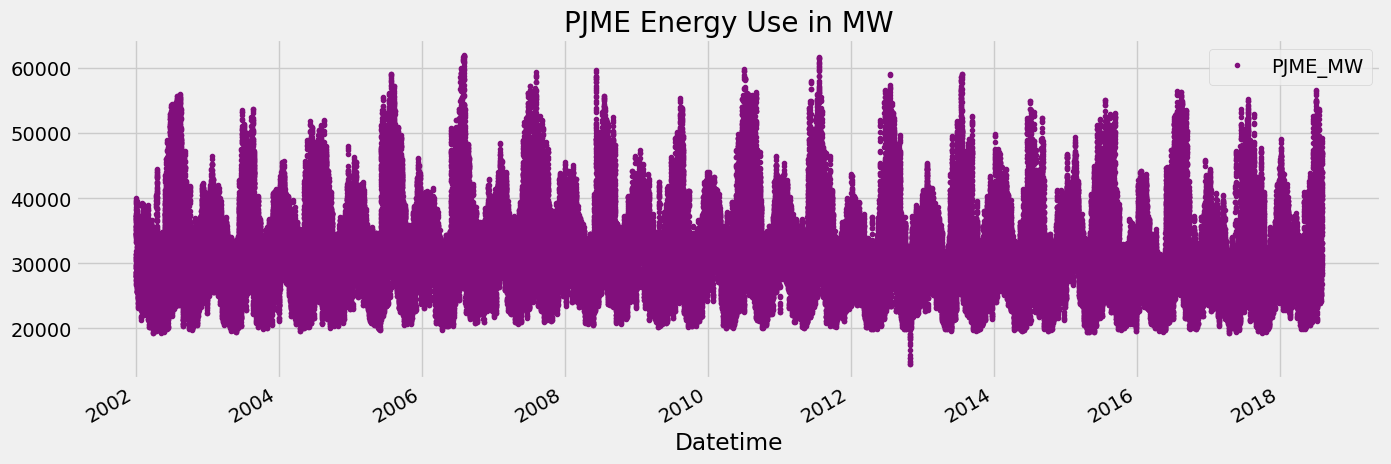

In [142]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[-1],
        title='PJME Energy Use in MW')

plt.show()

## Train Test splitting

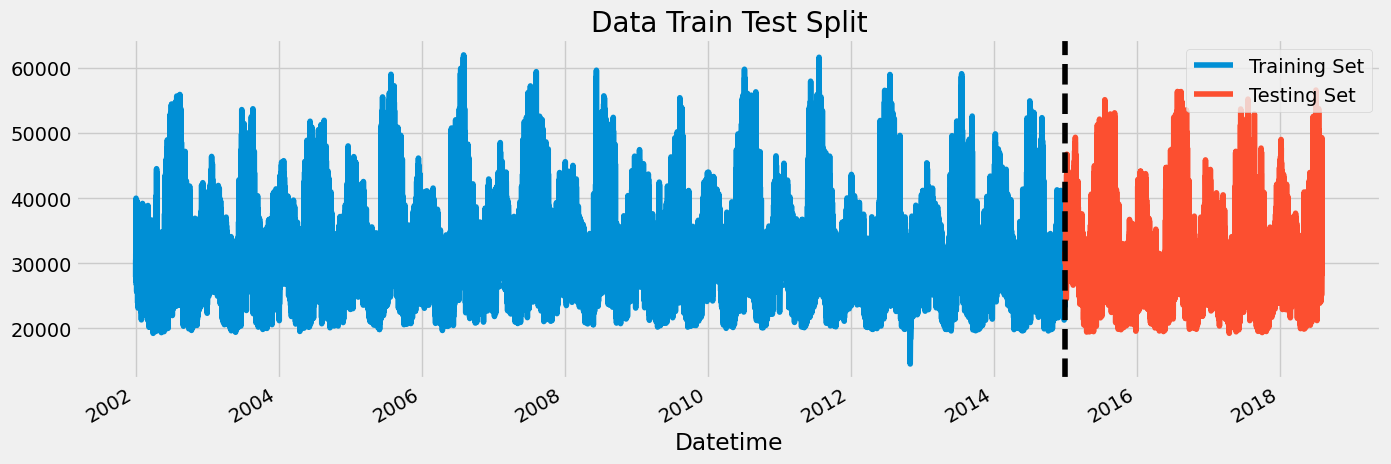

In [143]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Data Train Test Split")
test.plot(ax=ax, label="Testing Set")

ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])

plt.show()

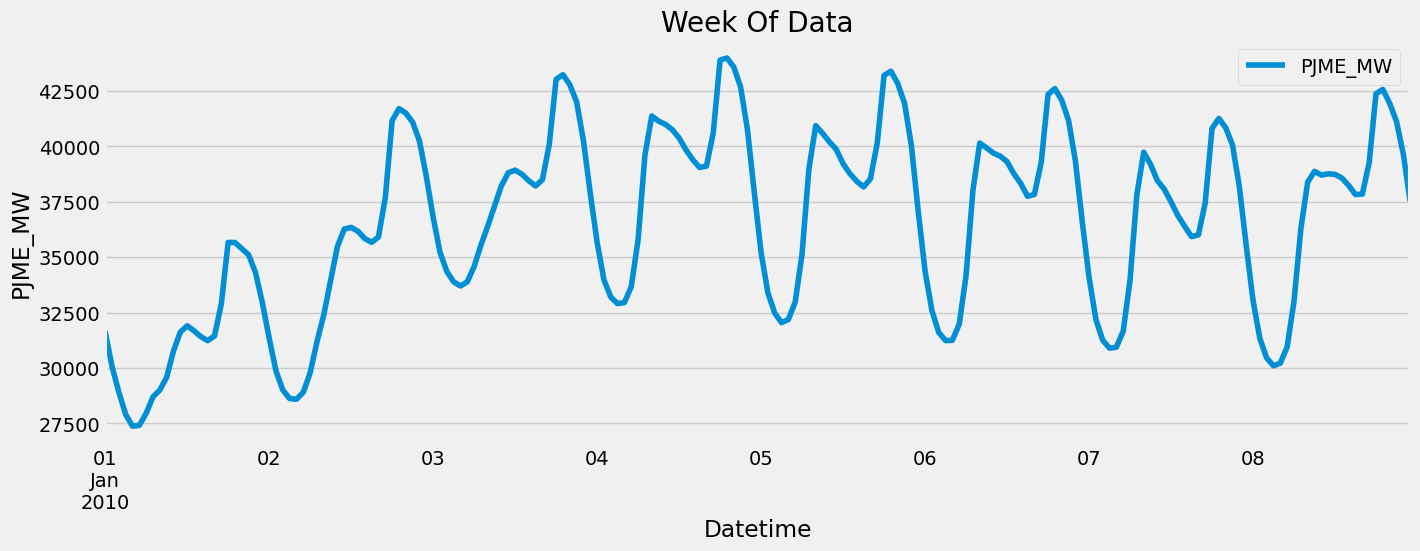

In [144]:
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

df.loc['2010-01-01':'2010-01-08'].plot(figsize=(15, 5), title='Week Of Data')
plt.xlabel("Datetime")
plt.ylabel("PJME_MW")
plt.show()

## Feature Creation

In [145]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [146]:
df = create_features(df)

## Visualize our Feature vs Target Relationship

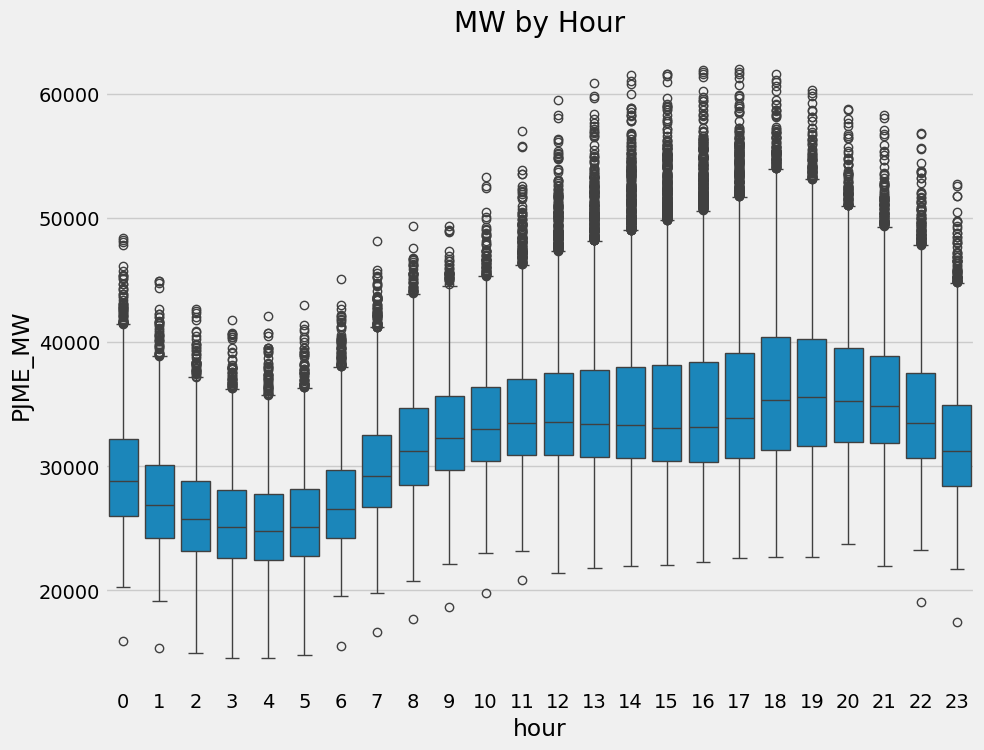

In [147]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

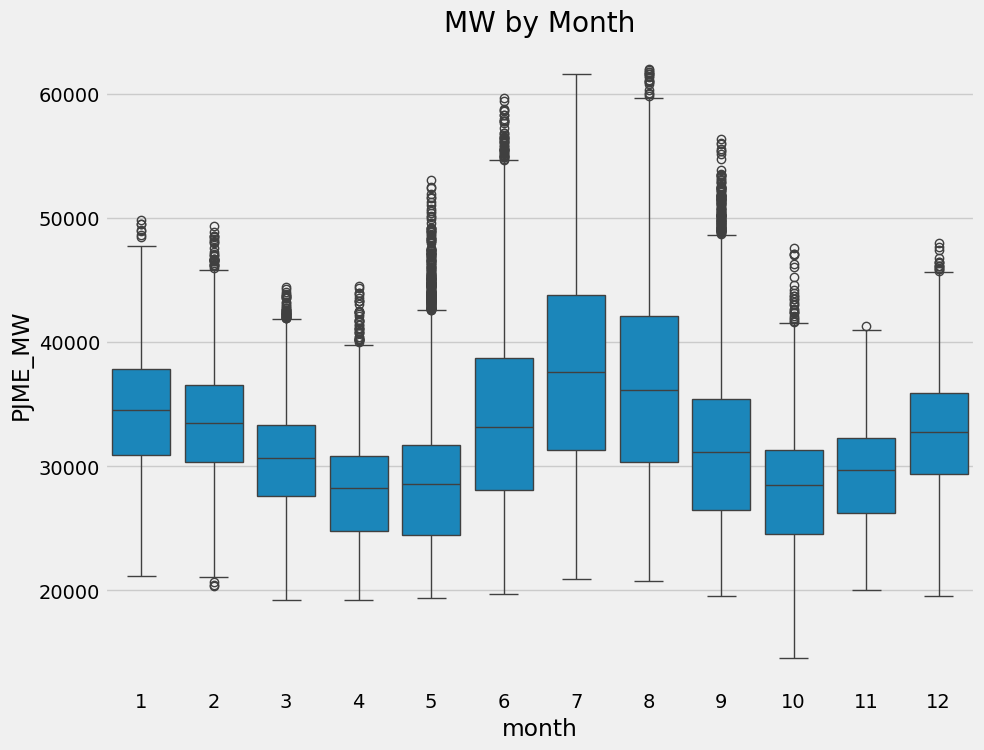

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

## Creating Model

In [149]:
train = create_features(train)
test = create_features(test)

In [150]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

In [151]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [152]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\xgboost\callback.py:386: UserWarning: [15:50:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


## Feature Importance

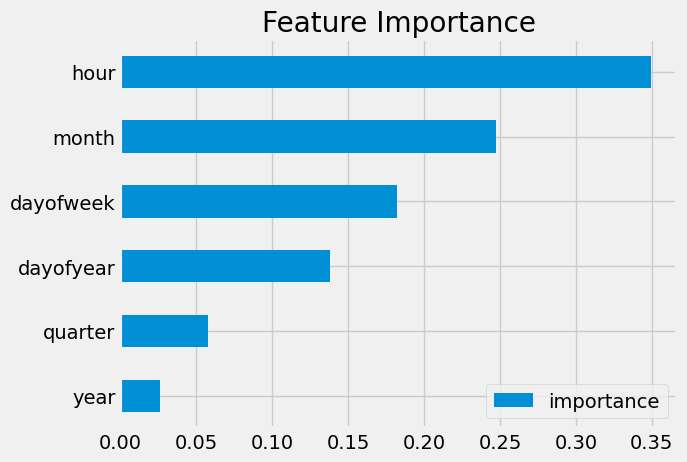

In [153]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [154]:
test['prediction'] = reg.predict(X_test)

In [ ]:
df_copy = df.copy()
df_copy = df_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

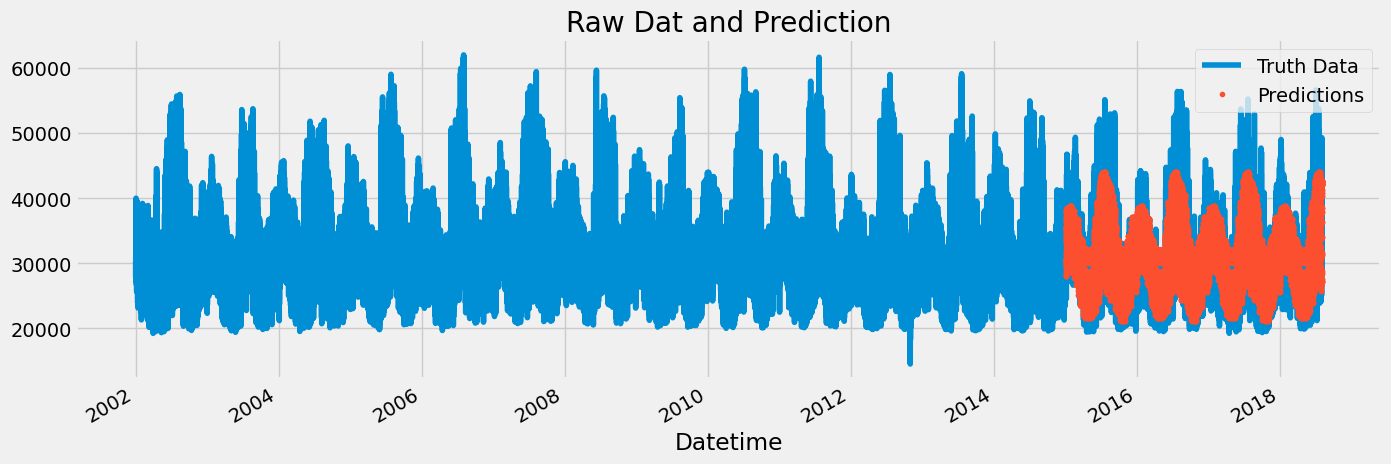

In [155]:
ax = df_copy[['PJME_MW']].plot(figsize=(15, 5))
df_copy['prediction'].plot(ax=ax, style='.')

plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

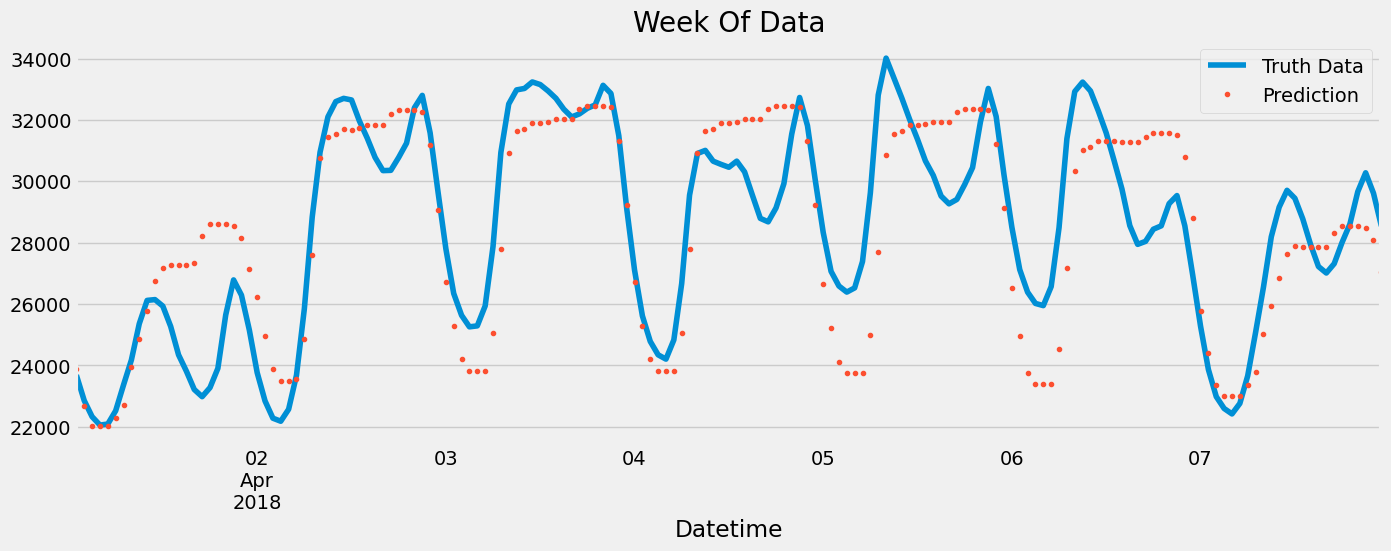

In [157]:
ax = df_copy.loc[(df_copy.index > '04-01-2018') & (df_copy.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_copy.loc[(df_copy.index > '04-01-2018') & (df_copy.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()